In [16]:
import cv2
import numpy as np
import onnxruntime as ort
from scipy.ndimage import maximum_filter
import matplotlib.pyplot as plt

# Constants
INPUT_SIZE = 224
DOWNSAMPLING_RATIO = 4
LABELS = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

# Load ONNX model
session = ort.InferenceSession("centernet_inference.onnx", providers=['CPUExecutionProvider'])
input_name = session.get_inputs()[0].name
print("Input name:", input_name)
print("Input shape:", session.get_inputs()[0].shape)

# Preprocess image
def preprocess_img(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (INPUT_SIZE, INPUT_SIZE)).astype(np.float32)
    return image

# Decode model outputs to bounding boxes
def decode_detections(heatmap, size_map, offset_map, threshold):
    pooled = maximum_filter(heatmap[0], size=3, mode='constant')
    peaks = (heatmap[0] == pooled) & (heatmap[0] > threshold)

    y_coords, x_coords, class_ids = np.where(peaks)
    scores = heatmap[0, y_coords, x_coords, class_ids]
    pred_sizes = size_map[0, y_coords, x_coords, :]
    pred_offsets = offset_map[0, y_coords, x_coords, :]

    boxes, decoded_scores, decoded_labels = [], [], []
    for i in range(len(scores)):
        px, py = x_coords[i], y_coords[i]
        w, h = pred_sizes[i]
        off_x, off_y = pred_offsets[i]

        center_x = (px + off_x) * DOWNSAMPLING_RATIO
        center_y = (py + off_y) * DOWNSAMPLING_RATIO

        x_min = center_x - w / 2
        y_min = center_y - h / 2
        x_max = center_x + w / 2
        y_max = center_y + h / 2

        boxes.append([x_min, y_min, x_max, y_max])
        decoded_scores.append(scores[i])
        decoded_labels.append(class_ids[i])

    return np.array(boxes), np.array(decoded_scores), np.array(decoded_labels)

Input name: input
Input shape: ['unk__1091', 224, 224, 3]


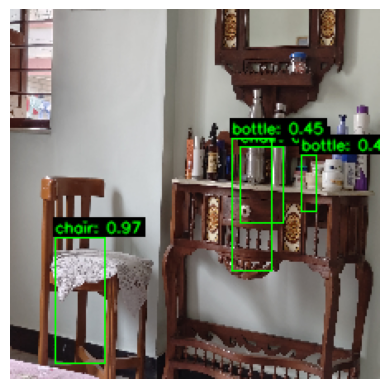

In [51]:
def run_inference_and_display(image_path, session, input_name, LABELS, preprocess_img, decode_detections, threshold=0.5):

    # Preprocess input
    image = preprocess_img(image_path)
    image_tensor = np.expand_dims(image, axis=0)
    
    # Run inference
    predictions = session.run(None, {input_name: image_tensor})
    pred_heatmap, pred_offset, pred_size = predictions

    # Prepare original image for drawing
    original_image = image.astype('uint8')

    # Decode outputs
    boxes, scores, labels = decode_detections(pred_heatmap, pred_size, pred_offset, threshold)

    # Draw bounding boxes and labels
    for i in range(len(boxes)):
        x_min, y_min, x_max, y_max = boxes[i].astype(int)
        score = scores[i]
        label_name = LABELS[int(labels[i])]
        text = f"{label_name}: {score:.2f}"

        # Draw bounding box
        cv2.rectangle(original_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 1)

        # Text styling
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.3
        thickness = 1
        (text_w, text_h), _ = cv2.getTextSize(text, font, font_scale, thickness)
        text_x, text_y = x_min, y_min - text_h + 4

        # Background for text
        cv2.rectangle(original_image,
                      (text_x - 1, text_y - text_h - 2),
                      (text_x + text_w + 1, text_y + 2),
                      (0, 0, 0), -1)

        # Draw text
        cv2.putText(original_image, text, (text_x, text_y), font, font_scale, (0, 255, 0), thickness, cv2.LINE_AA)

    # Show image
    plt.imshow(original_image)
    plt.axis('off')
    plt.show()

run_inference_and_display(
    image_path='/Users/saptarshimallikthakur/Desktop/IMG_20250714_103014.jpg',
    session=session,
    input_name=input_name,
    LABELS=LABELS,
    preprocess_img=preprocess_img,
    decode_detections=decode_detections,
    threshold=0.42
)

In [ ]:
import cv2
import numpy as np
import onnxruntime as ort
from scipy.ndimage import maximum_filter
import time

# Constants
INPUT_SIZE = 224
DOWNSAMPLING_RATIO = 4
LABELS = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

# Initialize ONNX Runtime session
session = ort.InferenceSession("centernet_inference.onnx", providers=['CPUExecutionProvider'])
input_name = session.get_inputs()[0].name

# Preprocessing
def preprocess(frame):
    img = cv2.resize(frame, (INPUT_SIZE, INPUT_SIZE)).astype(np.float32)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return np.expand_dims(img_rgb, axis=0)

# Decoding model output
def decode_detections(heatmap, size_map, offset_map, threshold):
    pooled = maximum_filter(heatmap[0], size=3, mode='constant')
    peaks = (heatmap[0] == pooled) & (heatmap[0] > threshold)

    y_coords, x_coords, class_ids = np.where(peaks)
    scores = heatmap[0, y_coords, x_coords, class_ids]
    pred_sizes = size_map[0, y_coords, x_coords, :]
    pred_offsets = offset_map[0, y_coords, x_coords, :]

    boxes, decoded_scores, decoded_labels = [], [], []
    for i in range(len(scores)):
        px, py = x_coords[i], y_coords[i]
        w, h = pred_sizes[i]
        off_x, off_y = pred_offsets[i]

        cx = (px + off_x) * DOWNSAMPLING_RATIO
        cy = (py + off_y) * DOWNSAMPLING_RATIO

        x_min, y_min = cx - w / 2, cy - h / 2
        x_max, y_max = cx + w / 2, cy + h / 2

        boxes.append([x_min, y_min, x_max, y_max])
        decoded_scores.append(scores[i])
        decoded_labels.append(class_ids[i])

    return np.array(boxes), np.array(decoded_scores), np.array(decoded_labels)

# Inference on video
def run_video_inference(video_path=0, threshold=0.7):
    cap = cv2.VideoCapture(video_path)
    prev_time = time.time()

    fps_video = cap.get(cv2.CAP_PROP_FPS) or 24  # fallback to 24 if property fails
    frame_time = 1.0 / fps_video

    while cap.isOpened():
        start_time = time.time()
        ret, frame = cap.read()
        if not ret:
            break

        input_tensor = preprocess(frame)
        predictions = session.run(None, {input_name: input_tensor})
        pred_heatmap, pred_offset, pred_size = predictions

        boxes, scores, labels = decode_detections(pred_heatmap, pred_size, pred_offset, threshold)

        h_orig, w_orig = frame.shape[:2]
        scale_x = w_orig / INPUT_SIZE
        scale_y = h_orig / INPUT_SIZE

        if boxes.shape[0] > 0:
            boxes[:, [0, 2]] *= scale_x  # x_min, x_max
            boxes[:, [1, 3]] *= scale_y  # y_min, y_max


        # Draw detections
        for i in range(len(boxes)):
            x_min, y_min, x_max, y_max = boxes[i].astype(int)
            label = LABELS[int(labels[i])]
            score = scores[i]
            text = f"{label}: {score:.2f}"

            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 1)

            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale, thickness = 0.4, 1
            (tw, th), _ = cv2.getTextSize(text, font, font_scale, thickness)
            text_x, text_y = x_min, y_min - th if y_min - th > 0 else y_min + th + 2

            cv2.rectangle(frame, (text_x - 1, text_y - th - 2), (text_x + tw + 1, text_y + 2), (0, 0, 0), -1)
            cv2.putText(frame, text, (text_x, text_y), font, font_scale, (0, 255, 0), thickness, cv2.LINE_AA)

        # FPS calculation
        curr_time = time.time()
        fps = 1 / (curr_time - prev_time)
        prev_time = curr_time

        cv2.putText(frame, f"FPS: {fps:.2f}", (10, 18), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)

        cv2.imshow("CenterNet Inference", frame)
        # Wait just enough to match video FPS
        elapsed = time.time() - start_time
        wait = max(1, int((frame_time - elapsed) * 1000))
        if cv2.waitKey(wait) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Run on webcam or provide path to video file
run_video_inference('/Users/saptarshimallikthakur/Desktop/video_20250713_091617.mp4')  # 0 for webcam, or replace with video path